In [1]:
import pandas as pd
import pandahouse
import seaborn as sns
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220620.feed_actions'}

In [3]:
q = '''
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions
WHERE toDate(time) between '2022-05-17' and '2022-05-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [6]:
# Проверим метрики в группах
df.groupby('exp_group', as_index=False)\
    .agg(users=('user_id', 'nunique'),
         mean_ctr=('ctr', 'mean'))

,exp_group,users,mean_ctr
0,2,8480,0.218246
1,3,8569,0.219161


<AxesSubplot:xlabel='ctr', ylabel='Count'>

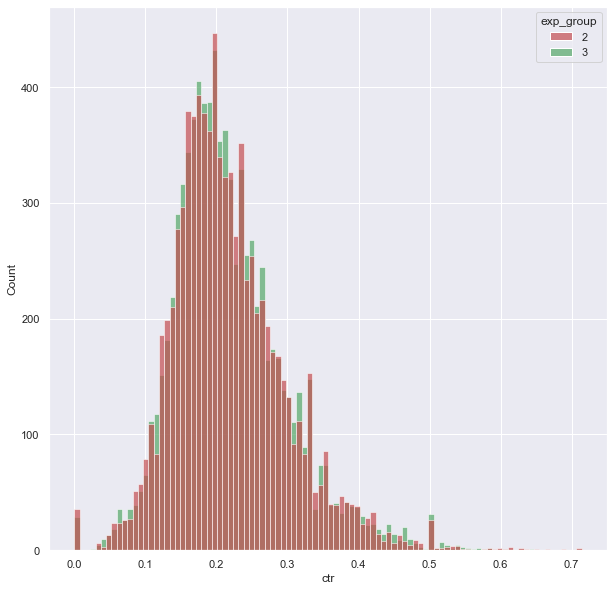

In [7]:
# Распределение ctr по группам
sns.set(rc={'figure.figsize': (10, 10)})

sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             alpha=0.7,
             palette=['r', 'g'])

In [8]:
group_2 = df.query('exp_group == 2')
group_3 = df.query('exp_group == 3')

In [62]:
def aa_test(group_a, group_b, test_num=10000, users_num=500):
    '''
    Проверка корректности сплитования с помощью многократного проведения t-теста.

    :param test_num: кол-во тестов
    :param users_num: кол-во юзеров в каждом тесте
    :param group_a: группа 1
    :param group_b: группа 2
    :return: ДФ с результатами теста, процент ложноположительного срабатывания
    '''

    # создание ДФ с результатами тестов
    index = 0
    res_df = pd.DataFrame(columns=['t_stat', 'p_value'])

    # цикл проведения тестов
    for _ in tqdm(range(test_num)):

        test_res = {'t_stat': ttest_ind(group_a.sample(users_num, replace=True),
                                        group_b.sample(users_num, replace=True),
                                        equal_var=False)[0],
                    'p_value': ttest_ind(group_a.sample(users_num, replace=True),
                                         group_b.sample(users_num, replace=True),
                                         equal_var=False)[1]}
        res_df = res_df.append(pd.DataFrame(data=test_res,
                                            index=[index]))
        index += 1

    fpr = sum(res_df.p_value <= 0.05) / res_df.shape[0]

    return res_df, fpr

In [63]:
aa_df, fpr = aa_test(group_2.ctr, group_3.ctr)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
fpr

0.0551

По итогам проведения А/А теста можно утверждать, что система сплитования работает не слишком корректно, так как уровень ложноположительного срабатывания выше принятого уровня стат. значимости.